In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import calendar
import sys
sys.path.append('../')  # Add the parent folder to the Python path

from sql_functions import get_dataframe  # Import the function

main_cities = [
    "New York, NY",
    "Washington, DC",
    "Philadelphia, PA",
]

side_cities = [
    "Miami, FL",
    "Houston, TX",
    "San Francisco, CA",
    "Seattle, WA"
]


In [3]:
query_2016 = '''
	SELECT * 
	FROM group3.flights_2016
	WHERE 
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
'''

query_2015 = '''
	SELECT * 
	FROM group3.flights_2015
	WHERE month = 12
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''

query_2017 = '''
	SELECT * 
	FROM group3.flights_2017 
	WHERE month = 1
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''


flights_2015 = get_dataframe(query_2015)
flights_2017 = get_dataframe(query_2017)
flights_2016 = get_dataframe(query_2016)

In [4]:
# Concatenate DataFrames of 2015, 2016 and 2017
flights_2016_2015_2017 = pd.concat([flights_2015, flights_2016, flights_2017], ignore_index=True)
%store flights_2016_2015_2017

Stored 'flights_2016_2015_2017' (DataFrame)


In [5]:
# Filter for cancelled flights with cancellation_code = "B"
cancelled_B_flights = flights_2016_2015_2017[(flights_2016_2015_2017['cancelled'] == 1) & (flights_2016_2015_2017['cancellation_code'] == "B")]

# Filter for flights that were not canceled and had a delay
not_cancelled_delayed_flights = flights_2016_2015_2017[((flights_2016_2015_2017['had_delay'] == 1) & ((flights_2016_2015_2017['arr_delay'] > 60) | (flights_2016_2015_2017['dep_delay'] > 60)))]

# Aggregate the counts for canceled flights and delayed flights that were not canceled
monthly_counts_cancelled = cancelled_B_flights.groupby(['year', 'month']).size().reset_index(name='cancelled')
monthly_counts_delayed = not_cancelled_delayed_flights.groupby(['year', 'month']).size().reset_index(name='had_delay')

# Merge the two counts on year and month
monthly_counts = monthly_counts_cancelled.merge(monthly_counts_delayed, on=['year', 'month'], how='outer').fillna(0)

# Mapping month numbers to month names
monthly_counts['month_name'] = monthly_counts['month'].apply(lambda x: calendar.month_name[x])
%store monthly_counts


Stored 'monthly_counts' (DataFrame)


### Comparing dates and cancelled flights per month

In [6]:
january = monthly_counts[(monthly_counts["year"] == 2016) & (monthly_counts["month"] == 1)]

print(f"The month of January 2016 we had a total of {january['cancelled']} cancelled flights and a total of {january['had_delay']} with significant delay")

The month of January 2016 we had a total of 1    867
Name: cancelled, dtype: int64 cancelled flights and a total of 1    40
Name: had_delay, dtype: int64 with significant delay


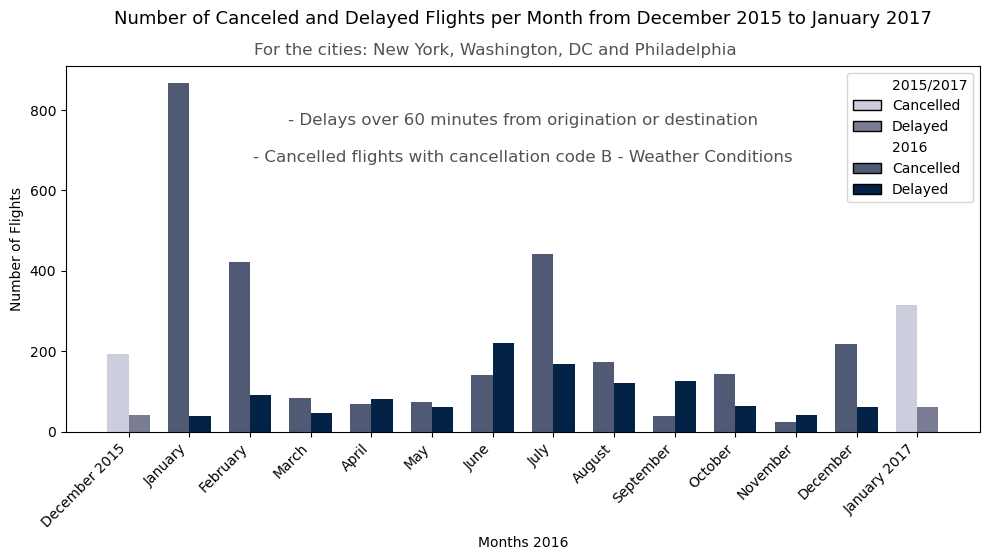

In [7]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))

bar_width = 0.35
index = range(len(monthly_counts))

for i, row in monthly_counts.iterrows():
    year = row['year']
    if i == 0 or i == len(monthly_counts) - 1:
        # Different color for the first and last months
        color_cancelled = '#cccddd'   # default color for 2015/2017
        color_delay = '#7a7c94'  # default color for 2015/2017
        label = f'{row["month_name"]} {year}'
    else:
        color_cancelled = '#505a74'  # Default color for 2016
        color_delay = '#022246'  # Default color for 2016
        label = row["month_name"]
    
    plt.bar(i - bar_width/2, row['cancelled'], bar_width, color=color_cancelled, label=f'Cancelled - {label}')
    plt.bar(i + bar_width/2, row['had_delay'], bar_width, color=color_delay, label=f'Delayed - {label}')

# Create custom legend
legend_elements = [
    Patch(facecolor='none', edgecolor='none', label='2015/2017'),  # Title for 2015/2017
    Patch(facecolor='#cccddd', edgecolor='black', label='Cancelled'),
    Patch(facecolor='#7a7c94', edgecolor='black', label='Delayed'),
    Patch(facecolor='none', edgecolor='none', label='2016'),  # Title for 2016
    Patch(facecolor='#505a74', edgecolor='black', label='Cancelled'),
    Patch(facecolor='#022246', edgecolor='black', label='Delayed')
]
plt.legend(handles=legend_elements, loc='upper right')

# Set title
plt.suptitle('For the cities: New York, Washington, DC and Philadelphia',color='#4E5356', fontsize=12, y=0.87)
plt.title('Number of Canceled and Delayed Flights per Month from December 2015 to January 2017',fontsize=13, pad=30)
plt.text(0.5, 0.85, '- Delays over 60 minutes from origination or destination',  horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)
plt.text(0.5, 0.75, '- Cancelled flights with cancellation code B - Weather Conditions',  horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)
plt.xlabel('Months 2016')
plt.ylabel('Number of Flights')

# Set x-axis ticks and labels with adjustment
plt.xticks(index, [f"{month} {year}" if i == 0 or i == len(monthly_counts) - 1 else month for i, (month, year) in enumerate(zip(monthly_counts['month_name'], monthly_counts['year']))], rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [8]:
# Calculate total cancelled flights in January
cancelled_january = monthly_counts[(monthly_counts['month'] == 1) & (monthly_counts['year'] != 2016)]['cancelled'].sum()

# Calculate total cancelled flights for the rest of the year
cancelled_rest_of_year = monthly_counts[(monthly_counts['month'] != 1) & (monthly_counts['year'] != 2016)]['cancelled'].sum()

# Calculate percentage
percentage_cancelled_january = (cancelled_january / cancelled_rest_of_year) * 100

print(f"The percentage of cancelled flights in January compared to the rest of the year is: {percentage_cancelled_january:.2f}%")


The percentage of cancelled flights in January compared to the rest of the year is: 162.69%


## Creating the chart for the time of the event in 2016
### 22.01.2016 to 28.01.2016

In [9]:
query_2016 = '''
	SELECT * 
	FROM group3.flights_2016
	WHERE flight_date  >= '2016-01-22'::timestamp
	AND flight_date <= '2016-01-28'::timestamp
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''

flights_2016_event = get_dataframe(query_2016)

In [10]:
# Filter for cancelled flights with cancellation_code = "B"
cancelled_B_flights_2016 = flights_2016_event[(flights_2016_event['cancelled'] == 1) & (flights_2016_event['cancellation_code'] == "B")]

# Filter for flights that were not canceled and had a delay
not_cancelled_delayed_flights_2016 = flights_2016_event[((flights_2016_event['had_delay'] == 1) & ((flights_2016_event['arr_delay'] > 30) | (flights_2016_event['dep_delay'] > 30)))]

# Aggregate the counts for canceled flights and delayed flights that were not canceled
monthly_counts_cancelled_2016 = cancelled_B_flights_2016.groupby(['day']).size().reset_index(name='cancelled')
monthly_counts_delayed_2016 = not_cancelled_delayed_flights_2016.groupby(['day']).size().reset_index(name='had_delay')

# Merge the two counts on year and month
monthly_counts_2016 = monthly_counts_cancelled_2016.merge(monthly_counts_delayed_2016, on=['day'], how='outer').fillna(0)


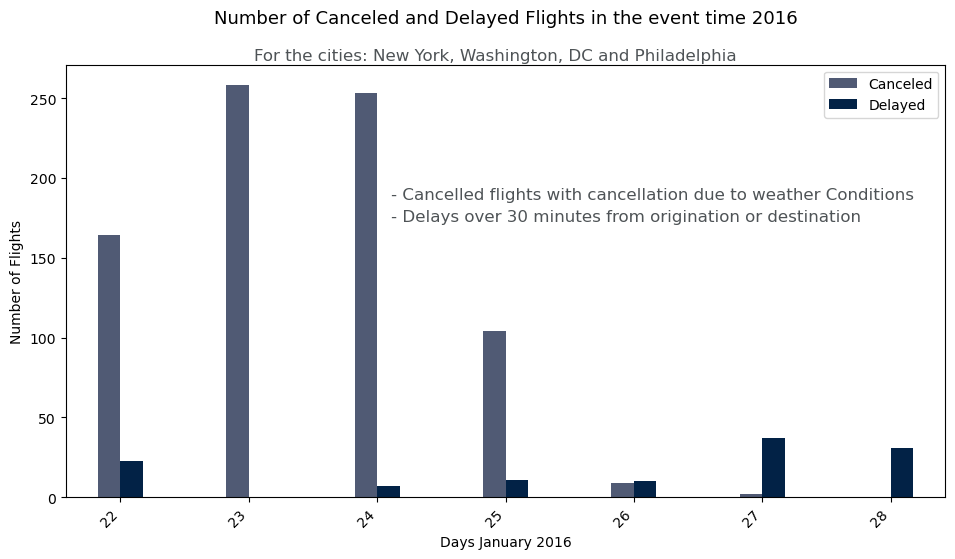

In [11]:
import matplotlib.pyplot as plt

# Set colors
color_cancelled = '#505a74'  # Default color for 2016
color_delay = '#022246'  # Default color for 2016

# Plotting the bar chart directly from the DataFrame
ax = monthly_counts_2016.plot(x='day', kind='bar', figsize=(10, 6), width=0.35, color=[color_cancelled, color_delay])

# Set title
plt.title('Number of Canceled and Delayed Flights in the event time 2016',fontsize=13, pad=30)
plt.suptitle('For the cities: New York, Washington, DC and Philadelphia',color='#4E5356', fontsize=12, y=0.86)

# Additional text
plt.text(0.37, 0.65, '- Delays over 30 minutes from origination or destination',  horizontalalignment='left', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)
plt.text(0.37, 0.70, '- Cancelled flights with cancellation due to weather Conditions',  horizontalalignment='left', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)

plt.xlabel('Days January 2016')
plt.ylabel('Number of Flights')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adding legend
plt.legend(['Canceled', 'Delayed'], loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


## Creating the chart for the time of the event in 2016 for the prior year - 2015
### 22.01.2015 to 28.01.2015

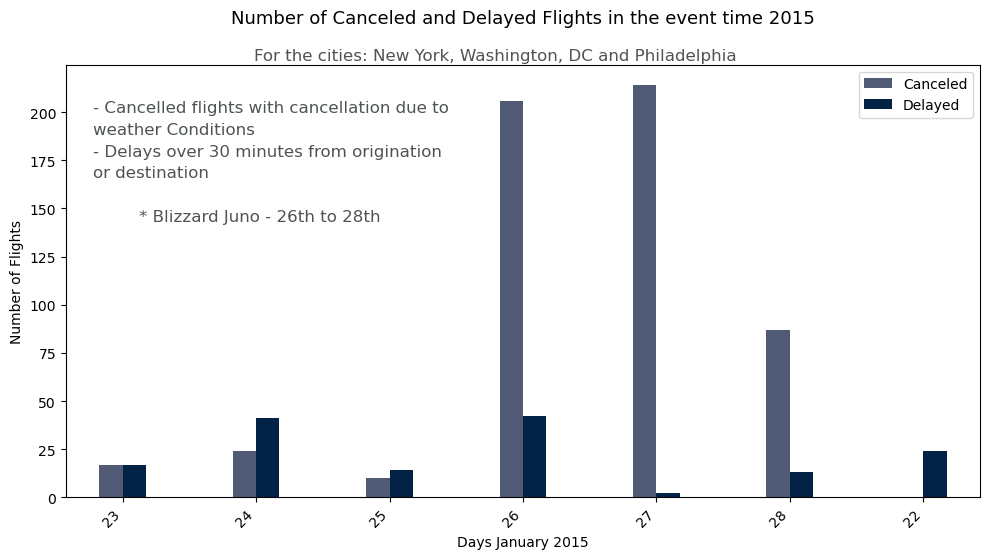

In [12]:
query_2015 = '''
	SELECT * 
	FROM group3.flights_2015
	WHERE flight_date  >= '2015-01-22'::timestamp
	AND flight_date <= '2015-01-28'::timestamp
	AND (
		origin IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		) 
		OR 
		destination IN (
			'New York, NY',
			'Washington, DC',
			'Philadelphia, PA'
		)
	);
'''


flights_2015_event = get_dataframe(query_2015)
# Filter for cancelled flights with cancellation_code = "B"
cancelled_B_flights_2015 = flights_2015_event[(flights_2015_event['cancelled'] == 1) & (flights_2015_event['cancellation_code'] == "B")]

# Filter for flights that were not canceled and had a delay
not_cancelled_delayed_flights_2015 = flights_2015_event[((flights_2015_event['had_delay'] == 1) & ((flights_2015_event['arr_delay'] > 30) | (flights_2015_event['dep_delay'] > 30)))]

# Aggregate the counts for canceled flights and delayed flights that were not canceled
monthly_counts_cancelled_2015 = cancelled_B_flights_2015.groupby(['day']).size().reset_index(name='cancelled')
monthly_counts_delayed_2015 = not_cancelled_delayed_flights_2015.groupby(['day']).size().reset_index(name='had_delay')

# Merge the two counts on year and month
monthly_counts_2015 = monthly_counts_cancelled_2015.merge(monthly_counts_delayed_2015, on=['day'], how='outer').fillna(0)


# Set colors
color_cancelled = '#505a74'  # Default color for 2015
color_delay = '#022246'  # Default color for 2015

# Plotting the bar chart directly from the DataFrame
ax = monthly_counts_2015.plot(x='day', kind='bar', figsize=(10, 6), width=0.35, color=[color_cancelled, color_delay])

# Set title
plt.title('Number of Canceled and Delayed Flights in the event time 2015',fontsize=13, pad=30)
plt.suptitle('For the cities: New York, Washington, DC and Philadelphia',color='#4E5356', fontsize=12, y=0.86)

# Additional text
plt.text(0.03, 0.90, '- Cancelled flights with cancellation due to',  horizontalalignment='left', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)
plt.text(0.03, 0.85, 'weather Conditions',  horizontalalignment='left', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)
plt.text(0.03, 0.80, '- Delays over 30 minutes from origination',  horizontalalignment='left', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)
plt.text(0.03, 0.75, 'or destination',  horizontalalignment='left', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)
plt.text(0.08, 0.65, '* Blizzard Juno - 26th to 28th',  horizontalalignment='left', verticalalignment='center',transform=plt.gca().transAxes, color='#4E5356', fontsize=12)

plt.xlabel('Days January 2015')
plt.ylabel('Number of Flights')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adding legend
plt.legend(['Canceled', 'Delayed'], loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


### Check the raise of cancelled flights from one year to another in percentage

In [13]:

# Calculate total canceled flights for Code B in each year
cancelled_2015 = flights_2015_event[flights_2015_event['cancellation_code'] == 'B']['cancelled'].sum()
cancelled_2016 = flights_2016_event[flights_2016_event['cancellation_code'] == 'B']['cancelled'].sum()

# Calculate percentage change
percentage_change = ((cancelled_2016 - cancelled_2015) / cancelled_2015) * 100

print("Increase in canceled flights for Code B from 2015 to 2016: {:.2f}%".format(percentage_change))

Increase in canceled flights for Code B from 2015 to 2016: 41.58%


In [14]:
# Calculate total delayed flights for each year
delayed_2015 = flights_2015_event['had_delay'].sum()
delayed_2016 = flights_2016_event['had_delay'].sum()

# Calculate percentage change
percentage_change = ((delayed_2016 - delayed_2015) / delayed_2015) * 100

print("Percentage change in delayed flights from 2015 to 2016: {:.2f}%".format(percentage_change))

Percentage change in delayed flights from 2015 to 2016: -25.54%


In [16]:
query_2016_other = '''
	SELECT * 
	FROM group3.flights_2016
	WHERE flight_date  >= '2016-01-22'::timestamp
	AND flight_date <= '2016-01-28'::timestamp
	AND (
		origin IN ('Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA') 
		OR 
		destination IN ('Miami, FL', 'Houston, TX', 'San Francisco, CA', 'Seattle, WA') 
	);
'''

flights_2016_event_other = get_dataframe(query_2016_other)

In [19]:
# 1. Group the data by coast
east_coast_total_flights = len(flights_2016_event)
west_coast_total_flights = len(flights_2016_event_other)

east_coast_cancelled = flights_2016_event[flights_2016_event['cancelled'] == 1].shape[0]
west_coast_cancelled = flights_2016_event_other[flights_2016_event_other['cancelled'] == 1].shape[0]

# 2. Calculate the total number of canceled flights for each coast
total_cancelled_east_coast = east_coast_cancelled
total_cancelled_west_coast = west_coast_cancelled

# 3. Calculate the percentage of canceled flights for each coast
percentage_cancelled_east_coast = (total_cancelled_east_coast / east_coast_total_flights) * 100
percentage_cancelled_west_coast = (total_cancelled_west_coast / west_coast_total_flights) * 100

# 4. Compare the percentage of canceled flights
difference_percentage_cancelled = percentage_cancelled_east_coast - percentage_cancelled_west_coast

print("Percentage of canceled flights on the East Coast:", percentage_cancelled_east_coast, "%")
print("Percentage of canceled flights on the West Coast:", percentage_cancelled_west_coast, "%")
print("Difference in percentage of canceled flights (East Coast - West Coast):", difference_percentage_cancelled, "%")


Percentage of canceled flights on the East Coast: 9.520204409955522 %
Percentage of canceled flights on the West Coast: 2.1193470698421195 %
Difference in percentage of canceled flights (East Coast - West Coast): 7.400857340113403 %
